In [ ]:
import logging as l
from pathlib import Path

import torch

from looped_experiments.all import *
from looped_experiments.eval import *
import looped_experiments.wandb_utils as wu

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20", "task.n_points=41","model.n_loops=100"]

In [ ]:
base = get_config()
# filter out runs that don't have a custom curriculum
filters = [lambda r: '_k' in r.name or r.name=="loop_L1_b20_T5_linear"]
runs = wu.get_runs(base.wandb.project, wu.default_filters+filters)

In [ ]:
wu.refresh_models(runs.values())

In [ ]:
errs = {}
for k, v in runs.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc) 

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

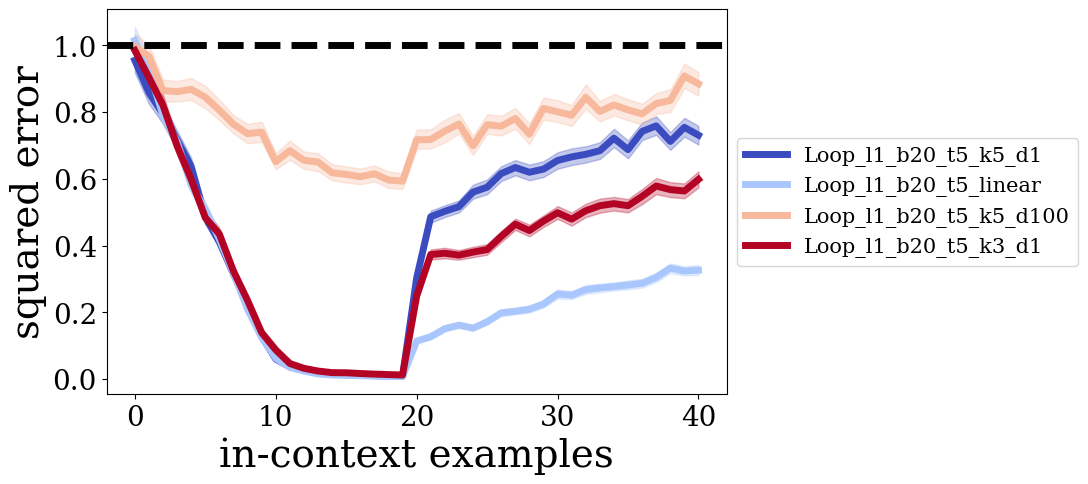

In [ ]:
plot_results(res)